In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ssm

from data_processing import *
from pca_analysis import *

np.random.seed(42)

In [2]:
import numpy as np

# dat_LFP = np.load('steinmetz_lfp.npz', allow_pickle=True)['dat']
# dat_WAV = np.load('steinmetz_wav.npz', allow_pickle=True)['dat']
dat_ST = np.load('steinmetz_st.npz', allow_pickle=True)['dat']


# select just one of the recordings here. 11 is nice because it has some neurons in vis ctx. 
# dat = dat_LFP[11]
# print(dat.keys())
# dat = dat_WAV[11]
# print(dat.keys())
dat = dat_ST[11]
print(dat.keys())

dict_keys(['ss', 'ss_passive'])


In [8]:
alldat = load_data()

In [90]:
dt = 0.01 # bin duration (ms)
t = np.arange(250)*dt
t -= 0.5 # set timestep 0 to stimulus onset 

In [4]:
def train_hmm(session, brain_area, n_states, start=0, stop=250, n_iters=100, passive=False):
    dat = alldat[session]

    if not passive:
        # take active trials
        spks = dat['spks'][dat['brain_area'] == brain_area]
        spks = spks[:,:,start:stop]
    else:
        # take passive trials
        spks = dat['spks_passive'][dat['brain_area'] == brain_area]
        
        passive_trials = (np.abs(dat['wheel_passive'][0]) < 2).all(axis=1)
        passive_spks = spks[:,passive_trials]
        print(np.count_nonzero(passive_trials))
        spks = passive_spks[:,:,start:stop]
    
    data= np.transpose(spks, (1,2,0)) # n_trials x n_timesteps x n_neurons

    # train/test split
    train_data, test_data, rdm_idx = data_split(data, int(0.8*len(data)))
    mean_spike_counts = train_data.mean(axis=(0,1))
    train_data = list(train_data)
    test_data = list(test_data)

    n_neurons = train_data[0].shape[1]
    
    # create the hmm
    hmm = ssm.HMM(n_states, n_neurons, observations="poisson", transitions="standard")

    # initialization
    init_lambdas = np.random.uniform(low=np.zeros_like(mean_spike_counts),
                                     high=mean_spike_counts, size=(n_states,n_neurons)) # n_states x n_neurons
    hmm.log_lambdas = np.log(init_lambdas + 1e-16)
    
    lls = hmm.fit(list(train_data), method='em', num_iters=n_iters)
    
    return hmm, lls, dat, rdm_idx, train_data, test_data


In [5]:
def plot_posterior(res, n_trials=10, plot_wheel=False, plot_face=False, plot_pupil=False, test=False, passive=False):
    hmm, lls, dat, rdm_idx, train_data, test_data = res

    dt = 0.01 # bin duration (ms)
    t = np.arange(train_data[0].shape[0])*dt
    t -= 0.5 # set timestep 0 to stimulus onset 
    print(len(train_data), len(test_data), rdm_idx.shape)
    for i in range(n_trials):
        if test:
            trial_spikes = test_data[i]
            trial_idx = rdm_idx[len(train_data)+i]
        else:
            trial_spikes = train_data[i]
            trial_idx = rdm_idx[i]
        print(trial_idx)
        
        if not passive:
            print_trial_outcome(dat, trial_idx)
        posterior = hmm.filter(trial_spikes)
        n_states = posterior.shape[1]

        # plot posterior of states for a single test trial
        fig = plt.figure(figsize=(7, 6))
        plt.title("Posterior distribution of the latent state")
        ax1 = plt.subplot(2, 1, 1)
        
        colors = ["cornflowerblue", "orange", "yellowgreen", "firebrick"]
        for i in range(posterior.shape[1]):
            plt.plot(t, posterior[:,i], label="State %d" % i, color=colors[i])

            
            if trial_idx == 148:
                plt.text(0.15, -0.12, "state on", va='top', ha='center', color="dimgrey")
                plt.text(0.55, -0.12, "mov on", va='top', ha='center', color="dimgrey")
    
                plt.axvline(0.15, linestyle="--", color="dimgrey")
                plt.axvline(0.55, linestyle="--", color="dimgrey")
                
#         if not passive:
# #             plt.axvline(0, color="black", linestyle="--")
# #             plt.axvline(dat['gocue'][trial_idx,0], color="black", linestyle=":")
# #             plt.axvline(dat['feedback_time'][trial_idx,0], color="black", linestyle="-", label="Feedback")
            
        plt.legend()
        plt.ylabel("Probability")
        
        if plot_wheel:
            ax2 = plt.subplot(2, 1, 2, sharex=ax1)
            
            if trial_idx == 148:
                plt.axvline(0.15, linestyle="--", color="black")
                plt.axvline(0.55, linestyle="--", color="black")

            if not passive:
                plt.plot(t, np.cumsum(dat['wheel'][0,trial_idx]), color="gray")
#                 plt.axvline(0, color="black", linestyle="--")
#                 plt.axvline(dat['gocue'][trial_idx,0], color="black", linestyle=":")
    #             plt.axvline(dat['feedback_time'][trial_idx,0], color="black", linestyle="-", label="Feedback")
#                 plt.plot(t, dat['wheel'][0,trial_idx])
            else:
                plt.plot(t, np.cumsum(dat['wheel_passive'][0,trial_idx]), color="gray")

            plt.xlabel("Time (s)")
            plt.ylabel("Wheel position")
            plt.setp(ax1.get_xticklabels(), visible=False)
            plt.show()
        else:
            
            plt.xlabel("Time (s)")
            plt.legend()
            plt.show()

            
def plot_hidden_states(res):
    hmm, lls, dat, rdm_idx, train_data, test_data = res    

    colors = ["cornflowerblue", "orange", "yellowgreen", "firebrick"]
    fig = plt.figure(figsize=(3, 6))
    for i, log_lambda in enumerate(hmm.observations.log_lambdas):
        plt.subplot(len(hmm.observations.log_lambdas), 1, i+1)
        plt.title("Latent state {}".format(i))
        plt.bar(np.arange(len(log_lambda)), np.exp(log_lambda), color=colors[i])
        plt.tick_params(which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
    plt.tight_layout()
    plt.show()

In [10]:
dat = alldat[25]
dat_ss = dat_ST[25]

In [72]:
session = 25
brain_area = "MOs"
n_states = 4

res_mos_active = train_hmm(session, brain_area, n_states, start=0, stop=250)

HBox(children=(FloatProgress(value=0.0), HTML(value='')))

In [78]:
hmm, _, _, rdm_idx, train_data, test_data = res_mos_active

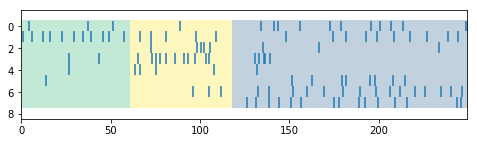

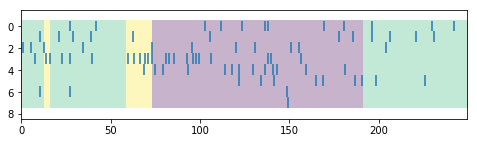

In [105]:
spk_times = dat_ss['ss'][dat['brain_area'] == "MOs"]
spks = dat['spks'][dat['brain_area'] == "MOs"]
l = [105, 38, 120, 71, 64, 57, 87, 161]

plt.figure(figsize=(8, 2))

ml_states = hmm.most_likely_states(test_data[np.argwhere(rdm_idx == 148)[0,0]-len(train_data)])
plt.imshow(np.tile(ml_states,len(l)).reshape(-1, 250), alpha=0.3, aspect="auto", vmin=0, vmax=n_states-1)

plt.eventplot((spk_times[l,148])*100)
plt.show()

plt.figure(figsize=(8, 2))

ml_states = hmm.most_likely_states(test_data[np.argwhere(rdm_idx == 88)[0,0]-len(train_data)])
plt.imshow(np.tile(ml_states,len(l)).reshape(-1, 250), alpha=0.3, aspect="auto", vmin=0, vmax=n_states-1)

plt.eventplot(spk_times[l,88]*100)
plt.show()